### Compare the effect of salary between different courses of study

In [13]:
# To make relative imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, FIG_DIR
from src.dataLoading import getAllCourses, getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedBruttoSalary
from src.salaryExpHelpers import modifySalary, plot
import numpy as np
from statsmodels.tsa.api import VAR
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import bundles

In [9]:
courses = getAllCourses()
# with open('courses.txt', 'w') as file:
#     for course in courses:
#         file.write(course + '\n')
courses = ['"Psychologie"']
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = courses, years = interestingYears)
print(totalStudents)
SECTOR = ('WZ08-62', 'Dienstleistungen der Informationstechnologie')
inflationAdjasutedBruttoSallary = getInflationAdjustedBruttoSalary(SECTOR)
sallaries = getSalaries()
SALLARY_YEARS = sallaries.index.levels[2]

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2


[  0. 706. 670. 756. 698. 772. 724. 769. 730. 787. 720. 784. 717. 827.
 725. 776. 699. 778. 678. 974. 822. 807. 685. 791. 693. 778. 657. 716.
 607. 634.]
Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust salary for inflation:
4211.5 -> 4116.813294232649
4251.0 -> 4155.4252199413495
4302.5 -> 4091.2133763897286
4317.0 -> 4105.001312231135
4349.0 -> 4127.175509276376
4375.0 -> 4151.8493568829945
4428.0 -> 4156.425367195795
4491.5 -> 4216.030834859963
4538.0 -> 4155.784325100693
4593.0 -> 4206.151918287238
4584.0 -> 4107.54398091299
4598.0 -> 4120.0888360030385
4597.0 -> 4054.323597367301
4655.5 -> 4105.9176653346685
4805.0 -> 4204.136083692842
4854.0 -> 4

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


In [10]:
PAST_STEPS = 4
PREDICTION_STPES = 2

completeData = np.column_stack((totalStudents, inflationAdjasutedBruttoSallary, graduatesInBW.repeat(2)))
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'salary', 'graduates'], dtype = 'float64')
model = VAR(completeDataDF)

results = model.fit(maxlags=PAST_STEPS)

/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


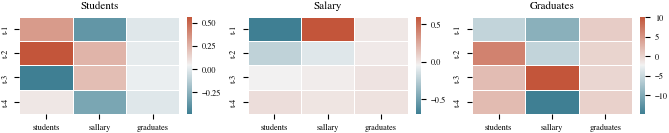

In [11]:
params = results.params.to_numpy()

paramsMatrices = []
titles = ['Students', 'Salary', 'Graduates']

for i in range(PAST_STEPS - 1):
    reshapedCoefficients = params[1:, i].reshape((PAST_STEPS, 3))
    df = pd.DataFrame(reshapedCoefficients)
    df.columns = ['students', 'sallary', 'graduates']
    df.index = ['t-1', 't-2', 't-3', 't-4']
    paramsMatrices.append(df)

plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=3, usetex=False))

fig, axs = plt.subplots(1, 3)

for i, df in enumerate(paramsMatrices):
    sns.heatmap(df, linewidths=0.5, ax=axs[i], cmap=sns.diverging_palette(220, 20, as_cmap=True))
    axs[i].set_title(titles[i])


plt.savefig(FIG_DIR + '/params_psycho.pdf')
plt.show()

### Forecasting
Modify the salary expectation, to see how the model would react.

#### 10% salary increase

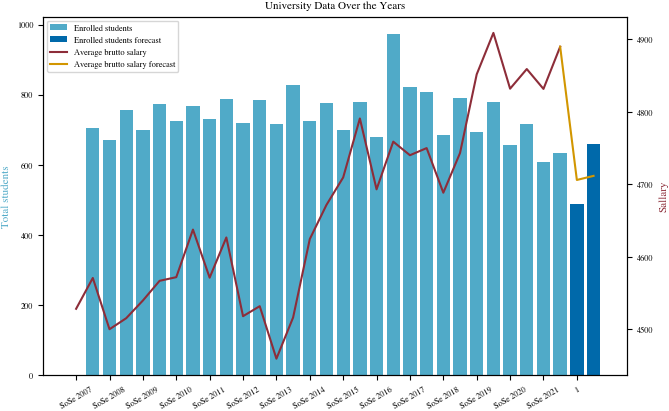

In [14]:
modifiedSalary = modifySalary(completeData, lambda x: x * 1.1)
lagged_values = modifiedSalary[-PAST_STEPS:]  # Use the last available values as lagged values
forecast = results.forecast(lagged_values, steps=PREDICTION_STPES)
plot(completeData, forecast, YEARS[3:-4])